## Variational Quantum Eigensolver

The Variational Quantum Eigensolver (VQE) is a flagship algorithm for quantum chemistry using near-term quantum computers. It is an application of the Rayleigh-Ritz variational principle, where a quantum computer is trained to prepare the ground state of a given system.

The inputs to the VQE algorithm are a molecular Hamiltonian and a parametrized circuit preparing the quantum state of the molecule. Within VQE, the cost function is defined as the expectation value of the Hamiltonian computed in the trial state. The ground state of the target Hamiltonian is obtained by performing an iterative minimization of the cost function. The optimization is carried out by a classical optimizer which leverages a quantum computer to evaluate the cost function and calculate its gradient at each optimization step.

As an illustrative example, we use it to find the ground state of the Hydrogen molecule, H2
 First, we build the molecular Hamiltonian using a minimal basis set approximation. Next, we design the quantum circuit preparing the trial state of the molecule, and the cost function to evaluate the expectation value of the Hamiltonian. Finally, we select a classical optimizer, initialize the circuit parameters, and run the VQE algorithm using an IBM noiseless Aer simulator.

In [11]:
# import necessary packages
# from qiskit import QuantumCircuit
import numpy as np
import matplotlib.pyplot as plt
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_algorithms.optimizers import L_BFGS_B, COBYLA
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit.circuit.library import TwoLocal

In [19]:
# Creating a class for the circuit
class Circuit:
    def __init__(self, molecule):
        self.molecule = molecule
        self.ham = self.create_hamiltonian(molecule=molecule)
        self.problem = self.create_problem(molecule=molecule)
        self.counts_noiseless = []
        self.values_noiseless = []
        self.seed = 170
    # Create the hamiltonian
    def create_hamiltonian(self, molecule, basis='sto3g'):
        """
        Create a Hamiltonian for a molecule using PySCFDriver
        and return the Hamiltonian as a PauliOp
        """
        driver = PySCFDriver(
            atom=self.molecule,
            unit=DistanceUnit.ANGSTROM,
            charge=0,
            spin=0,
            basis=basis
        )
        problem = driver.run()
        hamiltonian = problem.hamiltonian
        second_q_ham = hamiltonian.second_q_op()
        mapper = JordanWignerMapper()
        ham = mapper.map(second_q_ham)
        print("Created Hamiltonian successfully!")
        return ham
    # Create the problem
    def create_problem(self, molecule, basis='sto3g'):
        driver = PySCFDriver(
            atom=self.molecule,
            unit=DistanceUnit.ANGSTROM,
            charge=0,
            spin=0,
            basis=basis
        )
        problem = driver.run()
        return problem
    # We are using a Hardware Efficient Ansatz here
    def create_hea_circuit(self, num_qubits, entanglement_block='cx', entanglement='full', reps=5):
        n_gates_per_block = 3
        self.n_gates_per_block = n_gates_per_block
        rotation_block = ['rx', 'ry', 'rz']
        qc = TwoLocal(num_qubits=num_qubits, rotation_blocks=rotation_block, entanglement_blocks=entanglement_block, entanglement=entanglement, reps=reps)
        #qc.decompose().draw('mpl')
        return qc
    # Store the intermediate results of the VQE algorithm
    def store_intermediate_result_noiseless(self, eval_count, parameters, mean, std):
        self.counts_noiseless.append(eval_count)
        self.values_noiseless.append(mean)
    # Cost function for the VQE algorithm
    def cost_func(self, params, ansatz, hamiltonian, estimator):
        pub = (ansatz, [hamiltonian], [params])
        result = estimator.run(pubs=[pub]).result()
        energy = result[0].data.evs[0]
        self.cost_history_dict["iters"] += 1
        self.cost_history_dict["prev_vector"] = params
        self.cost_history_dict["cost_history"].append(energy)
        print(f"Iters. done: {self.cost_history_dict['iters']}, Energy: {energy}")
        return energy
    # Run the VQE algorithm
    def run_vqe_noiseless(self, ansatz, optimizer=L_BFGS_B(maxiter=1000)):
        noiseless_estimator = AerEstimator(
            backend_options={
                "method": "statevector"},
            run_options={"seed": self.seed,"shots": 10000}, 
            transpile_options={"seed_transpiler": self.seed},
            approximation=True
        )
        seed = 170
        optimizer = COBYLA(maxiter=2000)
        vqe = VQE(
            noiseless_estimator, 
            ansatz, 
            optimizer=optimizer, 
            callback=self.store_intermediate_result_noiseless
        )
        vqe_result = vqe.compute_minimum_eigenvalue(self.ham)
        print("Noiseless VQE ran successfully!")
        return vqe_result

### Defining the molecule and creating the ansatz

We are using a hardware efficient ansatz here

Created Hamiltonian successfully!
Created Hamiltonian successfully!


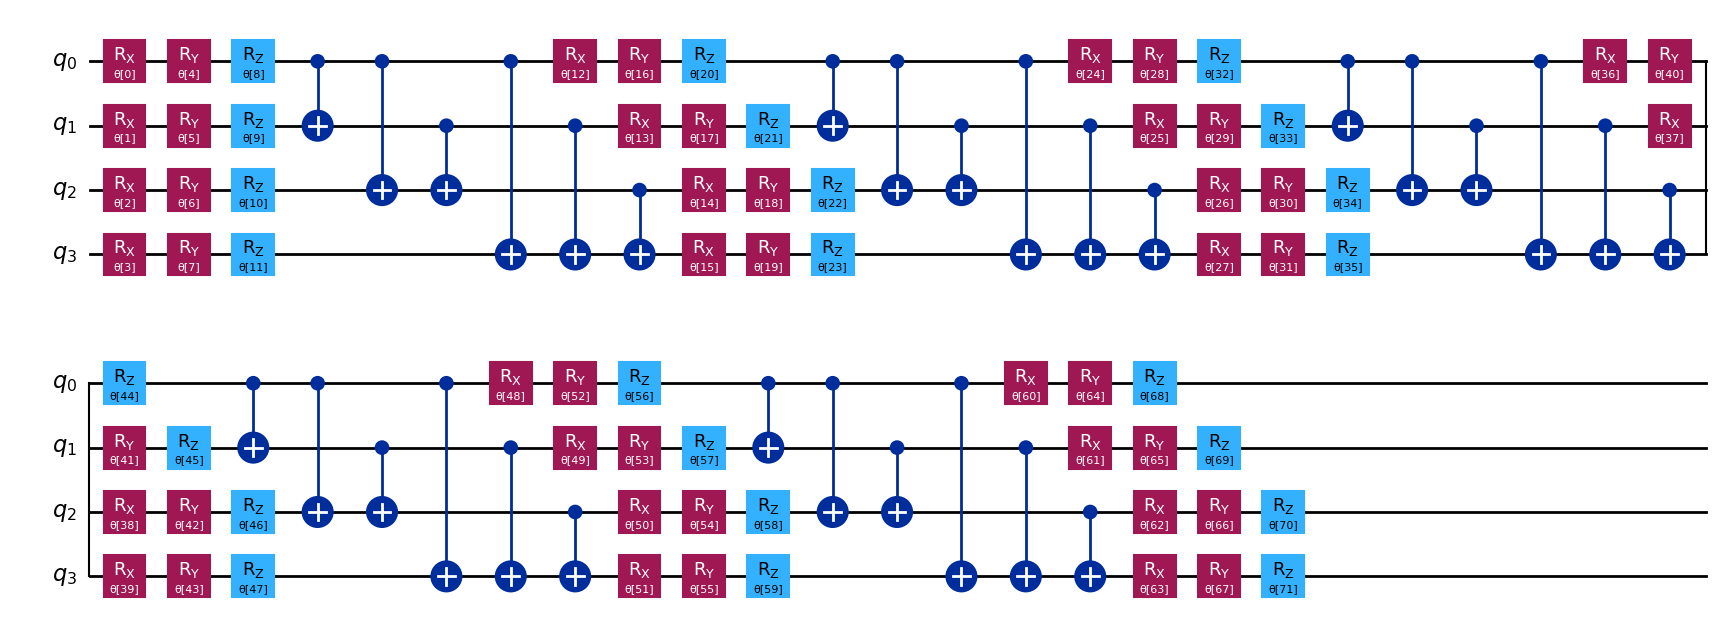

In [14]:
# Define the molecule
molecule_name = 'H2'
molecule = 'H .0 .0 .0; H .0 .0 0.74'

cir = Circuit(molecule) 
ham = cir.create_hamiltonian(molecule)
num_qubits = ham.num_qubits
molecule = cir.create_problem(molecule)
nuclear_repulsion_energy = molecule.nuclear_repulsion_energy

ansatz = cir.create_hea_circuit(num_qubits)

ansatz.decompose().draw('mpl')  

In [15]:
# solve using VQE
vqe_result = cir.run_vqe_noiseless(ansatz)

Noiseless VQE ran successfully!


In [16]:
print("VQE result: ", vqe_result.eigenvalue)
print("Nuclear repulsion energy: ", nuclear_repulsion_energy)

VQE result:  -1.8514518615464717
Nuclear repulsion energy:  0.7151043390810812


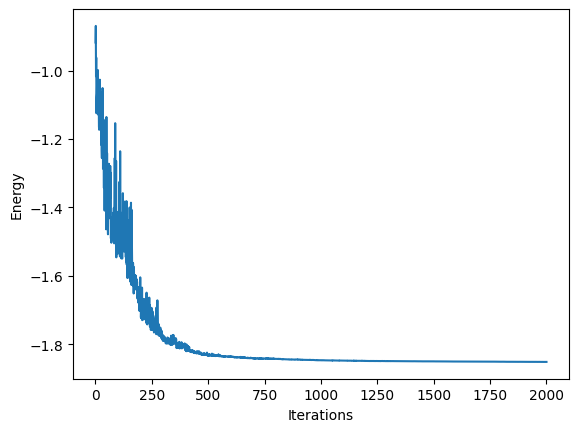

In [20]:
# plot the cost history
counts = cir.counts_noiseless
values = cir.values_noiseless

plt.plot(counts, values)
plt.xlabel("Iterations")
plt.ylabel("Energy")
plt.show()